<a href="https://colab.research.google.com/github/JesseTNRoberts/Do-Language-Models-Have-Rational-Preference/blob/main/Travelers/Population_Travelers_Dilemma_Preference_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
!pip install researchpy
import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install nbformat --upgrade
# !pip install seaborn --upgrade

In [ ]:
# Assuming your CSV file is named "data.csv"
from google.colab import drive
drive.mount('/content/drive')
loc = "/content/drive/MyDrive/Data/"

models = [
          # 'distilbert-base-uncased',
          # 'bert-base-uncased',
          # 'bert-large-uncased',
          # 'roberta-base',
          # 'roberta-large',
          # 'xlm-roberta-large',
          # 'electra-large-generator',
          # 'openai-gpt', 'distilgpt2',
          # 'gpt2',
          # 'gpt2-medium',
          # 'open_llama_13b',
          # 'llama-2-7b',
          # 'llama-2-13b',
          # 'alpaca-7b',
          # 'Mistral-7B-v0.1',
          # 'gemma-7b',
          'SOLAR-10.7B-v1.0',
          # 'phi-2',
          ]

Mounted at /content/drive


In [34]:
def get_df(loc, select_reduction=1):

  df = pd.read_csv(loc)

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(lambda x: x.replace('nan', '0'))
  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)
  df.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)



  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
      axis=1)

  df['rank'] = df['rank'].astype('float')
  df['item'] = df['item'].astype('int')


  df['experiment'] = df['preamble'].apply(lambda x: x[0:-5])
  df['experiment'] = df.groupby('experiment').ngroup()+1

  df = df.explode('population data')
  df['member id'] = df.groupby(['item', 'preamble','category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')

  rosch_val = 'rank'
  # rosch_val = 'label'
  # rosch_val = 'experiment'


  df['normalized'] = df.groupby(['category',rosch_val])['population data'].transform(lambda x: x/np.mean(x))

  return df


In [35]:
# loop through all models and calculate the per category correlation and significance with typicality
import plotly.graph_objects as go

prob_results = pd.DataFrame()
std_results = {}
all = pd.DataFrame()

exp = 'travelers'

for model in models:

  try:
    df = get_df(loc+'rational/'+exp+'/'+model+".csv")
    df['model'] = model
    base_df = get_df(loc+'rational/'+ exp +'/base/'+model+".csv")
    base_df['model'] = model
  except:
    continue

  all = pd.concat([all, df])

  rosch_val = 'rank'
  # rosch_val = 'label'
  # rosch_val = 'experiment'

  # std = df.groupby(['category',rosch_val]).aggregate({'normalized':np.std})
  # std['means'] = df.groupby(['category',rosch_val])['normalized'].mean()
  # std = std.reset_index()


  test = 'spearman'
  # test = 'pearson'
  # test = 'kendall'

  categories = ['best','worst']



  temp = df.groupby(['member id', 'category'])[[rosch_val,'population data']].corr(method=test).reset_index()
  temp = temp[['rank','member id','category']]
  temp = temp[temp['rank']!=1]
  temp['model'] = model
  temp['params'] = df['params'].unique()[0]
  prob_results = pd.concat([prob_results,temp])


  temp = base_df.groupby(['category'])[[rosch_val,'population data']].corr(method=test).reset_index()
  temp = temp[['rank','category']]
  temp = temp[temp['rank']!=1]
  temp['model'] = model
  temp['params'] = df['params'].unique()[0]
  temp['member id'] = 0
  prob_results = pd.concat([prob_results,temp])


<Axes: title={'center': 'population data'}, xlabel='item'>

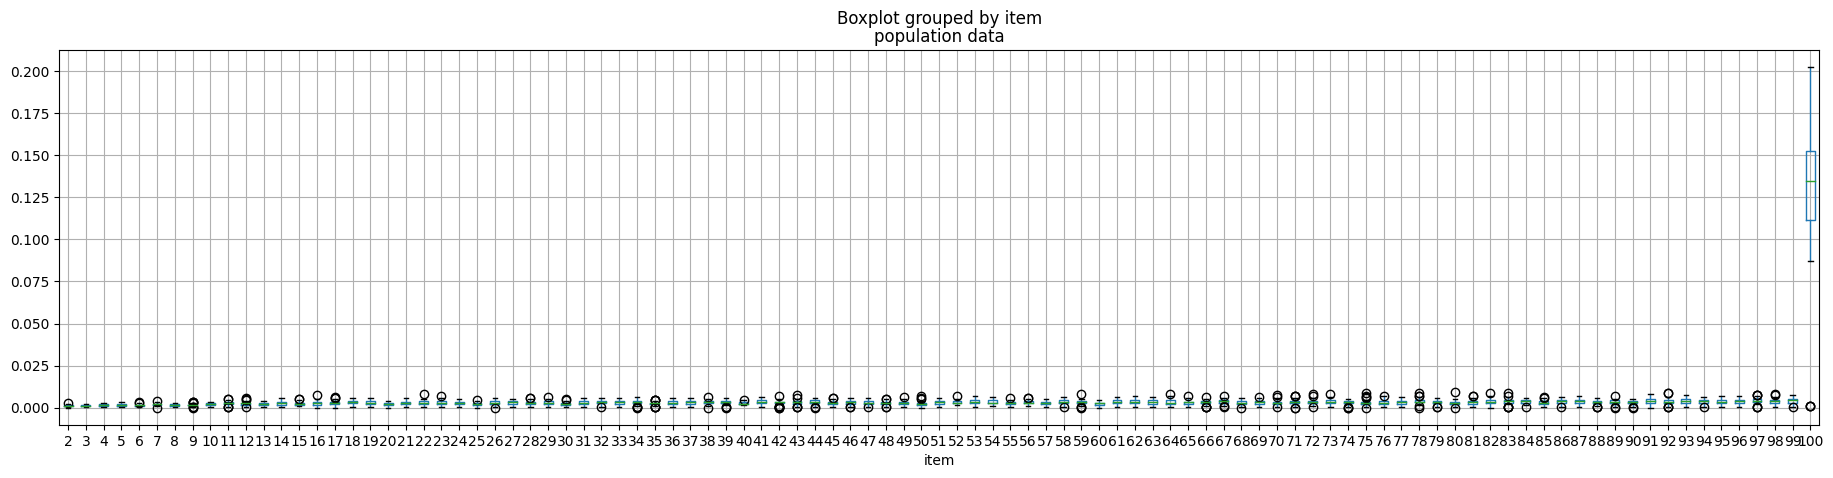

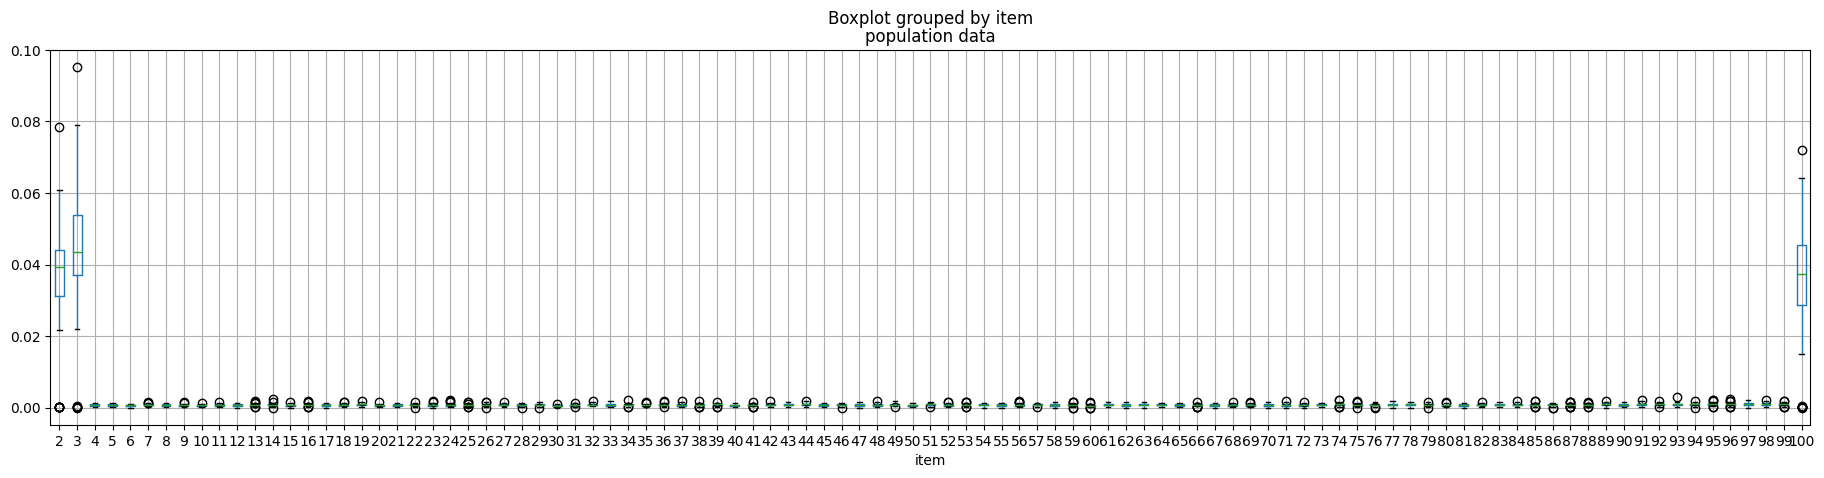

In [40]:
all[all['category']=='best'].boxplot(column='population data', by='item', figsize=(22,5))
all[all['category']=='worst'].boxplot(column='population data', by='item', figsize=(22,5))

In [26]:

# test = prob_results.sort_values(by='params')

f, axarr = plt.subplots(2, figsize=(13,8), sharex=True, gridspec_kw={'height_ratios': [2, 2]})

# function to alternate background color
def alt_bands(ax=None, highlight = None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    count = 0
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        if count == highlight:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
        else:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
        count+= 1
    ax.set_xlim(x_left, x_right)



# third Plot
# big = 2
# plt.xlabel('Models Ordered by Parameter Count')
# axarr[big].set_ylabel('Correlation of Assessment\nProbability\nwith Point Value')

# sns.swarmplot(x='model', # Group labels
#               y='rank', # Numeric variable
#               palette='Set2', # Color set used
#               hue='category', # Add a legend
#               size=3,
#               data=test[test['member id']>0],
#               dodge=True,
#               ax = axarr[big]
#              )
# sns.boxplot(x='model', y='rank', data=test[test['member id']>0],
#         boxprops={'facecolor':'None'}, color = 'gray',
#         showfliers=False,whiskerprops={'linewidth':0},
#         ax = axarr[big],
#         hue='category', zorder=50, legend=None)

# sns.scatterplot(x='model', y='rank', data=test[test['member id']==0],
#                   marker="*", s=150, zorder=100, palette =['purple', 'gray'], hue='category',
#                   ax = axarr[big])

# axarr[big].annotate('Each dot is a dropout population member \nof the given species.',
#                   xy=(6, 0.25), xycoords='data', alpha=0.7,
#                   xytext=(4.4, 0.35), textcoords='data',
#                   size=10, va="center", ha="center",
#                   # bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   fc="gray", ec='gray'))

# axarr[big].annotate('Star represents the \nspecies base model.',
#                   xy=(10.8, 0.67), xycoords='data', alpha=0.7,
#                   xytext=(9, 0.75), textcoords='data',
#                   size=10, va="center", ha="center",
#                   # bbox=dict(boxstyle="round4", fc="w"),
#                   arrowprops=dict(arrowstyle="-|>",
#                                   fc="gray", ec='gray'))

# axarr[big].legend(title='Predicted Assessment Word', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1),ncol=2)
plt.margins(x=0.01)
plt.subplots_adjust(hspace = 0)

# First plot
small = 0
axarr[small].tick_params(bottom=False)
axarr[small].title.set_text('Effect of Strategy Point Value on Language Model Assessment Probability')

temp = all[all['member id']>0]
# temp = all
this = temp.groupby(['model','category','member id','item'])['population data'].mean().reset_index()

test = this.groupby(['model','category'])['population data'].min().reset_index()
test['min'] = test['population data']
test['max'] = this.groupby(['model','category'])['population data'].max().reset_index()['population data']
test = test.drop('population data', axis='columns')
test = this.merge(test, how='right')

this['population data'] = (test['population data'] - test['min'])/(test['max'] - test['min'])

that = temp.groupby(['model','category','item','member id'])['params'].first().reset_index()
this = this.merge(that, how='right')



sns.swarmplot(x='item', # Group labels
              y='population data', # Numeric variable
              palette='Set2', # Color set used
              # hue='item', # Add a legend
              size=2,
              data=this[this['category']=='best'].sort_values(by='params'),
              dodge=True,
              ax = axarr[small]
             )

# axarr[small].title.set_text('Model Assessment Probability vs Strategy Point Value')
plt.xlabel('Models Ordered by Parameter Count')

axarr[small].set_ylabel("Relative Probability\nof 'Best'\nvs Point Value\n \n ")
axarr[small].set(yticklabels=[])
axarr[small].tick_params(left=False)
# axarr[small].legend(title='Strategy Point Value', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1),ncol=10, markerscale=2)


# second plot
small = 1

temp = this[this['category']=='worst']
# temp['rank'] = 4-temp['rank']

sns.swarmplot(x='item', # Group labels
              y='population data', # Numeric variable
              palette='Set2', # Color set used
              # hue='item', # Add a legend
              size=2,
              data=temp.sort_values(by='params'),
              dodge=True,
              ax = axarr[small]
             )

# axarr[small].title.set_text('Model Assessment Probability vs Strategy Point Value')
plt.xlabel('Models Ordered by Parameter Count')

axarr[small].set_ylabel("Relative Probability\nof 'Worst'\nvs Point Value\n \n ")
axarr[small].set(yticklabels=[])
axarr[small].tick_params(left=False)
# axarr[small].legend(title='Strategy Point Value', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0, 1),ncol=10, markerscale=2)

plt.xticks(rotation=30, ha="right")

# alt_bands(axarr[0], highlight=8)
# alt_bands(axarr[1], highlight=8)
# alt_bands(axarr[2], highlight=8)

plt.show()




KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7bb234d1d000> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7bb234d1c280> (for post_execute):


KeyboardInterrupt: 